* https://github.com/ml4a/ml4a/blob/master/examples/info_retrieval/image-search.ipynb
* https://github.com/ml4a/ml4a/blob/master/examples/info_retrieval/image-tsne.ipynb

`find . -type f -mindepth 2 -name '*.*' -exec rename -n 's!/([^/]+)$!_$1!' {} +`

In [1]:
import os
import random
import numpy as np
import json
import matplotlib.pyplot
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE
import os
import keras
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

%matplotlib inline

In [2]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

2021-12-28 14:32:17.370023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 14:32:17.662417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-28 14:32:17.662474: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-28 14:32:17.664172: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
!ls 101_ObjectCategories

accordion	   cougar_body	    garfield	  menorah     snoopy
airplanes	   cougar_face	    gerenuk	  metronome   soccer_ball
anchor		   crab		    gramophone	  minaret     stapler
ant		   crayfish	    grand_piano   Motorbikes  starfish
BACKGROUND_Google  crocodile	    hawksbill	  nautilus    stegosaurus
barrel		   crocodile_head   headphone	  octopus     stop_sign
bass		   cup		    hedgehog	  okapi       strawberry
beaver		   dalmatian	    helicopter	  pagoda      sunflower
binocular	   dollar_bill	    ibis	  panda       tick
bonsai		   dolphin	    inline_skate  pigeon      trilobite
brain		   dragonfly	    joshua_tree   pizza       umbrella
brontosaurus	   electric_guitar  kangaroo	  platypus    watch
buddha		   elephant	    ketch	  pyramid     water_lilly
butterfly	   emu		    lamp	  revolver    wheelchair
camera		   euphonium	    laptop	  rhino       wild_cat
cannon		   ewer		    Leopards	  rooster     windsor_chair
car_side	   Faces	    llama	  saxophone   wrench
ceiling_fan	   Faces_e

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


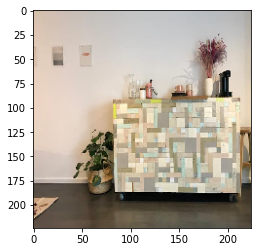

In [6]:
img, x = load_image("data/images_one_folder/49688506_2.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [7]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted desk with probability 0.164
predicted carton with probability 0.147
predicted dining_table with probability 0.068
predicted bookcase with probability 0.051
predicted library with probability 0.047


In [8]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

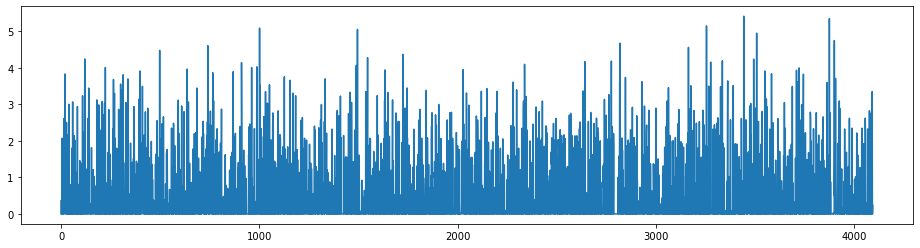

In [9]:
img, x = load_image("data/images_one_folder/49688506_2.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [10]:
images_path = 'data/images_one_folder/'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 11000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 10239 images to analyze


In [11]:
features = []
for i, image_path in enumerate(images):
    if i % 50 == 0:
        print("analyzing image %d / %d." % (i, len(images)))
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 10239.
analyzing image 50 / 10239.
analyzing image 100 / 10239.
analyzing image 150 / 10239.
analyzing image 200 / 10239.
analyzing image 250 / 10239.
analyzing image 300 / 10239.
analyzing image 350 / 10239.
analyzing image 400 / 10239.
analyzing image 450 / 10239.
analyzing image 500 / 10239.
analyzing image 550 / 10239.
analyzing image 600 / 10239.
analyzing image 650 / 10239.
analyzing image 700 / 10239.
analyzing image 750 / 10239.
analyzing image 800 / 10239.
analyzing image 850 / 10239.
analyzing image 900 / 10239.
analyzing image 950 / 10239.
analyzing image 1000 / 10239.
analyzing image 1050 / 10239.
analyzing image 1100 / 10239.
analyzing image 1150 / 10239.
analyzing image 1200 / 10239.
analyzing image 1250 / 10239.
analyzing image 1300 / 10239.
analyzing image 1350 / 10239.
analyzing image 1400 / 10239.
analyzing image 1450 / 10239.
analyzing image 1500 / 10239.
analyzing image 1550 / 10239.
analyzing image 1600 / 10239.
analyzing image 1650 / 10239.
ana

In [12]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=50)
pca.fit(features)

PCA(n_components=50)

In [13]:
pca_features = pca.transform(features)

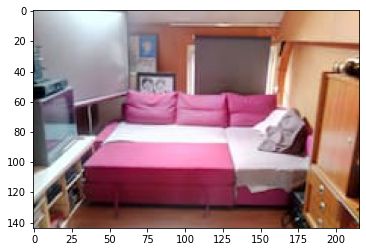

In [14]:
import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [15]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [16]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

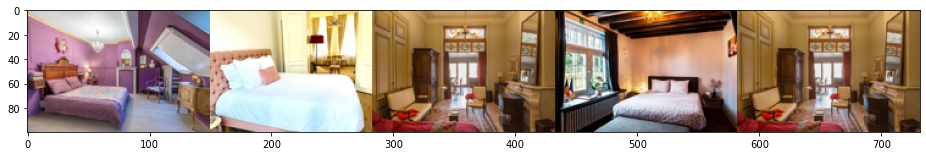

In [17]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [18]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'result images')

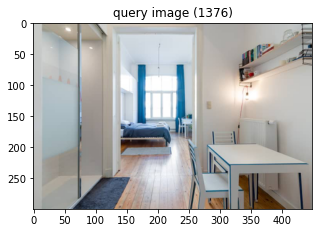

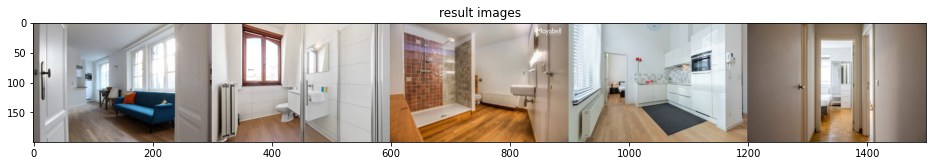

In [19]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

Text(0.5, 1.0, 'result images')

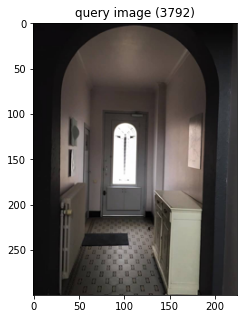

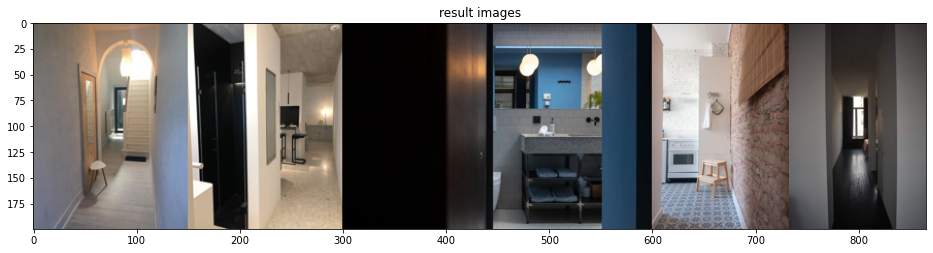

In [20]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [21]:
import pickle

pickle.dump([images, pca_features, pca], open('data/features/features_from_one_folder.p', 'wb'))